## Created on Mon June 24 2024

## @author: Jeong-Woon, Park

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'TMEM45B'),
  Text(1, 0, 'KCNJ11'),
  Text(2, 0, 'KRT5'),
  Text(3, 0, 'CDH3'),
  Text(4, 0, 'MAPT'),
  Text(5, 0, 'TYMS'),
  Text(6, 0, 'MYBL2'),
  Text(7, 0, 'FAM83D'),
  Text(8, 0, 'ESR1'),
  Text(9, 0, 'FOXC1'),
  Text(10, 0, 'NAT1'),
  Text(11, 0, 'SFRP1')])

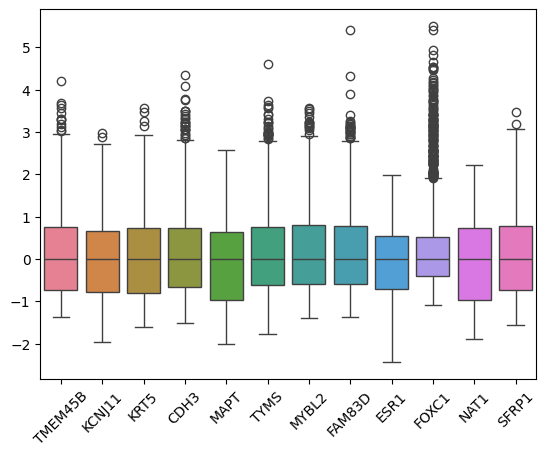

In [2]:
# Load X_train gene expression dataset.
X_train = pd.read_csv("/home/wjddns037/Code/Project_code/X_train_feature_select.csv", sep = "\t")
X_train.index = X_train.loc[:, "Unnamed: 0"].tolist()
X_train = X_train.drop(columns = ["Unnamed: 0"])

# Feature distritubion after normalization
plt.rcdefaults()
sns.boxplot(X_train)
plt.xticks(rotation = 45)

In [3]:
# Load PAM50 subtype dataset.
target = pd.read_csv("/home/wjddns037/Code/Project_code/GPL11154_PAM50.csv", sep = "\t")
target.index = target.loc[:, "Unnamed: 0"].tolist()
target = target.drop(columns = ["Unnamed: 0"])
target.head()

,BRCA_Subtype_PAM50
GSM2528079,Basal
GSM2528080,LumA
GSM2528081,LumB
GSM2528082,LumA
GSM2528084,Basal


In [4]:
# Load test PAM50 subtype dataset.
y_train = target.loc[X_train.index.tolist(), :]
y_train.head()

,BRCA_Subtype_PAM50
GSM2528830,Her2
GSM2530511,LumA
GSM2529478,LumA
GSM2528452,LumA
GSM2531266,LumB


In [5]:
# Label Encoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

In [6]:
# Downsampling based on k-means cluster,
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state = 42)
X_res, y_res = cc.fit_resample(X_train, y_train)

Text(0, 0.5, 'Frequency')

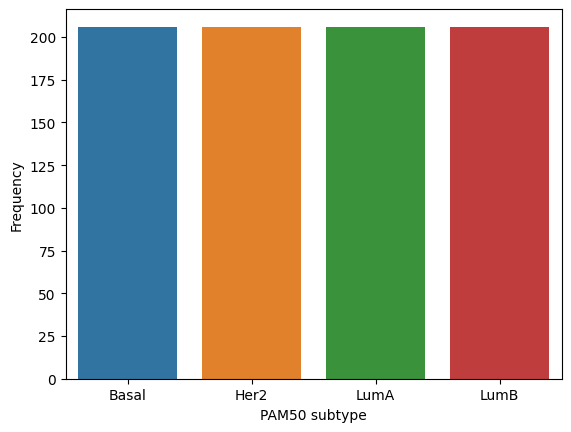

In [7]:
# Check count for each class in the training data.
class_counts = pd.Series(y_res).groupby(y_res).size()
class_counts.index = ["Basal", "Her2", "LumA", "LumB"]
sns.barplot(x = class_counts.index, y = class_counts.values, hue = class_counts.index)
plt.xlabel("PAM50 subtype")
plt.ylabel("Frequency")

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score, make_scorer, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve
from imblearn.metrics import specificity_score, sensitivity_score

# Model fitting and prediction.
model = clf = LogisticRegression(random_state = 42, penalty = "elasticnet", solver = "saga", 
                                 max_iter = 10000, C = 0.1, l1_ratio = 0.7)
model.fit(X_res, y_res)

LogisticRegression(C=0.1, l1_ratio=0.7, max_iter=10000, penalty='elasticnet',
                   random_state=42, solver='saga')

### Model performance using independent data (GSE81538)

In [9]:
# Load test gene expression dataset (GSE81538).
# The gene expression values were defined as log2(TPM + 1).
GSE81538_feature = pd.read_csv("/home/wjddns037/Code/Project_code/GSE81538_feature_scale.csv", sep = "\t")
GSE81538_feature.index = GSE81538_feature.loc[:, "Unnamed: 0"].tolist()
GSE81538_feature = GSE81538_feature.drop(columns = ["Unnamed: 0"])

GSE81538_feature = GSE81538_feature.loc[:, X_train.columns.tolist()]
GSE81538_feature.shape

(383, 12)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'TMEM45B'),
  Text(1, 0, 'KCNJ11'),
  Text(2, 0, 'KRT5'),
  Text(3, 0, 'CDH3'),
  Text(4, 0, 'MAPT'),
  Text(5, 0, 'TYMS'),
  Text(6, 0, 'MYBL2'),
  Text(7, 0, 'FAM83D'),
  Text(8, 0, 'ESR1'),
  Text(9, 0, 'FOXC1'),
  Text(10, 0, 'NAT1'),
  Text(11, 0, 'SFRP1')])

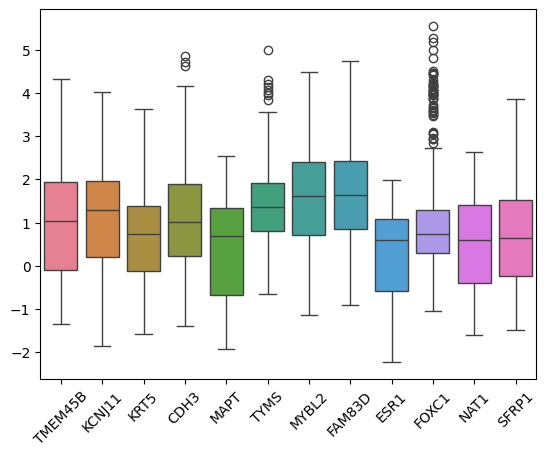

In [10]:
# Feature distritubion after normalization
plt.rcdefaults()
sns.boxplot(GSE81538_feature)
plt.xticks(rotation = 45)

In [11]:
# Load test PAM50 dataset.
GSE81538_target = pd.read_csv("/home/wjddns037/Code/Project_code/GSE81538_PAM50.csv", sep = "\t")
GSE81538_target.index = GSE81538_target.loc[:, "Unnamed: 0"].tolist()
GSE81538_target = GSE81538_target.drop(axis = 1, columns = ["Unnamed: 0"])

GSE81538_target = encoder.transform(GSE81538_target)
GSE81538_target

array([0, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 3, 1, 1, 3, 1, 1, 0, 1, 2, 0, 3, 0, 1, 0, 1, 1, 0, 1, 3, 1, 0,
       3, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 0, 0, 1, 2, 2, 2, 1, 2,
       2, 2, 2, 0, 2, 3, 0, 3, 2, 2, 0, 0, 3, 1, 2, 1, 2, 1, 1, 3, 3, 2,
       0, 2, 2, 3, 2, 0, 3, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 3, 0, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 3, 2, 2, 1, 0, 0, 0, 2, 3, 2, 2, 0,
       0, 2, 2, 3, 3, 2, 3, 2, 0, 2, 2, 3, 2, 0, 2, 3, 2, 3, 2, 2, 1, 0,
       3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 0, 2,
       2, 3, 1, 0, 3, 3, 1, 3, 3, 0, 1, 0, 3, 3, 3, 0, 3, 2, 0, 3, 3, 3,
       1, 1, 3, 2, 1, 2, 2, 2, 2, 0, 3, 3, 2, 2, 1, 2, 2, 3, 3, 2, 2, 3,
       2, 2, 3, 2, 3, 3, 2, 1, 3, 0, 3, 2, 2, 1, 1, 3, 3, 3, 3, 3, 3, 3,
       2, 0, 3, 0, 0, 3, 2, 0, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 2, 3,
       2, 2, 3, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 2, 3, 2, 0, 0, 3, 2,
       3, 2, 3, 3, 2, 2, 1, 0, 3, 2, 1, 2, 3, 2, 3,

In [12]:
# Prediction
y_pred = model.predict(GSE81538_feature)
y_pred_proba = model.predict_proba(GSE81538_feature)

In [13]:
# Classification report
print(classification_report(GSE81538_target, y_pred, target_names = ["Basal", "Her2", "LumA", "LumB"]))

              precision    recall  f1-score   support

       Basal       1.00      0.98      0.99        57
        Her2       0.81      0.88      0.84        65
        LumA       0.95      0.88      0.92       156
        LumB       0.80      0.86      0.83       105

    accuracy                           0.89       383
   macro avg       0.89      0.90      0.90       383
weighted avg       0.89      0.89      0.89       383



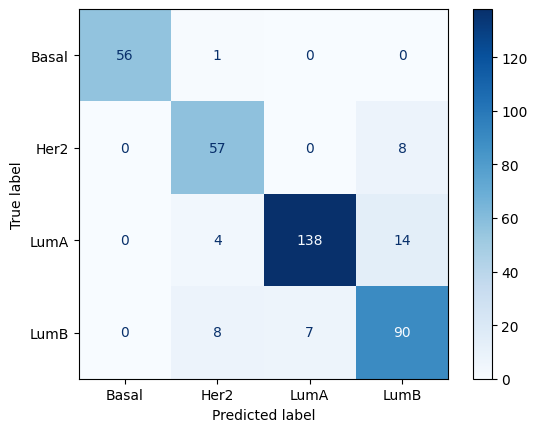

In [14]:
# Confusion matrix
plt.rcdefaults()
display = ConfusionMatrixDisplay.from_estimator(model, GSE81538_feature, GSE81538_target,
                                                display_labels = ["Basal", "Her2", "LumA", "LumB"],
                                                cmap = plt.cm.Blues, normalize = None)
plt.grid(False)
plt.show()

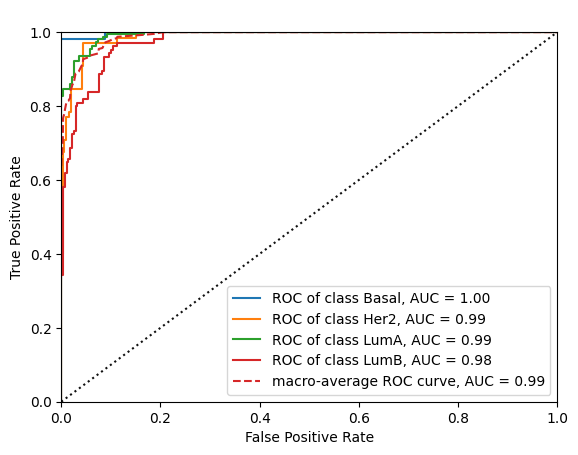

<Axes: title={'center': ' '}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [15]:
# ROC curve
plt.rcdefaults()
visualizer = ROCAUC(model, classes = ["Basal", "Her2", "LumA", "LumB"], macro = True, micro = False, title = " ")

visualizer.fit(X_res, y_res)        
visualizer.score(GSE81538_feature, GSE81538_target)       
visualizer.show()

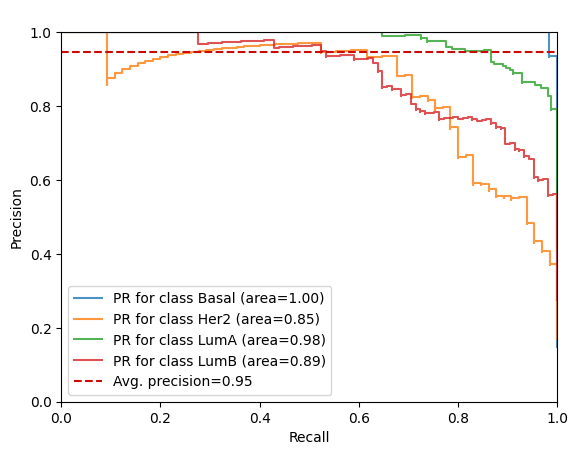

<Axes: title={'center': ' '}, xlabel='Recall', ylabel='Precision'>

In [16]:
# Precision-Recall curve
plt.rcdefaults()
visualizer = PrecisionRecallCurve(model, classes = ["Basal", "Her2", "LumA", "LumB"], micro = True, per_class = True, title = " ")

visualizer.fit(X_res, y_res)        
visualizer.score(GSE81538_feature, GSE81538_target)
visualizer.show()

In [17]:
# accuracy
accuracy_score(GSE81538_target, y_pred)

0.8903394255874674

In [18]:
# Macro average sensitivity
sensitivity_score(GSE81538_target, y_pred, average = "macro")

0.900284364758049

In [19]:
# Macro average specificity
specificity_score(GSE81538_target, y_pred, average = "macro")

0.9622864504506444

In [20]:
# Macro average F1 score
f1_score(GSE81538_target, y_pred, average = "macro")

0.8955078740186521

In [21]:
# Macro average AUROC
roc_auc_score(GSE81538_target, y_pred_proba, multi_class = "ovr", average = "macro")

0.9886324203700576

### Model performance using independent data (GPL18573)

In [22]:
# Load test gene expression dataset (GPL18573).
# The gene expression values were defined as log2(TPM + 1).
GPL18573_feature = pd.read_csv("/home/wjddns037/Code/Project_code/GPL18573_feature_scale.csv", sep = "\t")
GPL18573_feature.index = GPL18573_feature.loc[:, "Unnamed: 0"].tolist()
GPL18573_feature = GPL18573_feature.drop(columns = ["Unnamed: 0"])

GPL18573_feature = GPL18573_feature.loc[:, X_train.columns.tolist()]
GPL18573_feature.shape

(282, 12)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'TMEM45B'),
  Text(1, 0, 'KCNJ11'),
  Text(2, 0, 'KRT5'),
  Text(3, 0, 'CDH3'),
  Text(4, 0, 'MAPT'),
  Text(5, 0, 'TYMS'),
  Text(6, 0, 'MYBL2'),
  Text(7, 0, 'FAM83D'),
  Text(8, 0, 'ESR1'),
  Text(9, 0, 'FOXC1'),
  Text(10, 0, 'NAT1'),
  Text(11, 0, 'SFRP1')])

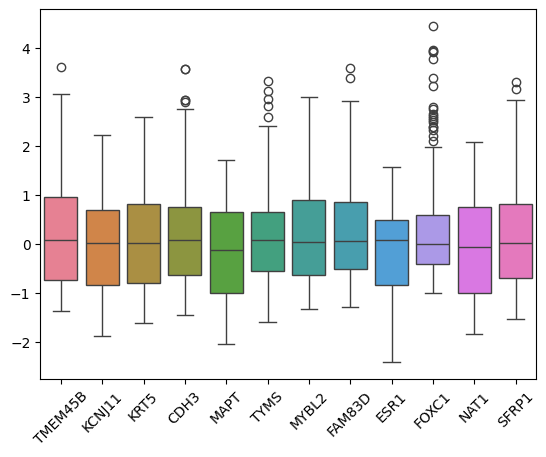

In [23]:
# Feature distritubion after normalization
plt.rcdefaults()
sns.boxplot(GPL18573_feature)
plt.xticks(rotation = 45)

In [24]:
# Load test PAM50 dataset.
GPL18573_target = pd.read_csv("/home/wjddns037/Code/Project_code/GPL18573_PAM50.csv", sep = "\t")
GPL18573_target.index = GPL18573_target.loc[:, "Unnamed: 0"].tolist()
GPL18573_target = GPL18573_target.drop(axis = 1, columns = ["Unnamed: 0"])

GPL18573_target = encoder.transform(GPL18573_target)
GPL18573_target

array([0, 2, 2, 2, 3, 1, 2, 3, 2, 1, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 0,
       3, 3, 2, 0, 0, 2, 1, 2, 2, 3, 2, 0, 2, 2, 2, 0, 3, 3, 3, 2, 3, 1,
       2, 0, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1,
       2, 2, 2, 2, 3, 3, 3, 1, 2, 2, 3, 0, 2, 2, 2, 3, 1, 2, 1, 1, 2, 0,
       2, 2, 0, 3, 1, 3, 2, 3, 3, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 0, 1, 3, 2, 0, 2, 2, 3, 2,
       3, 2, 2, 2, 1, 2, 1, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 3, 3, 2, 0, 1,
       2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 0, 2, 1, 0, 2, 3, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 3, 1, 2, 3, 1, 3, 0, 2, 2, 2, 2, 3, 2, 2, 2,
       3, 2, 2, 2, 0, 0, 1, 3, 2, 2, 2, 3, 2, 3, 3, 1, 2, 2, 3, 2, 2, 3,
       2, 0, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 3, 3, 1, 2, 2, 2, 2, 3, 2,
       3, 3, 3, 3, 2, 0, 0, 3, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2,
       1, 0, 2, 1, 2, 0, 3, 2, 2, 3, 3, 1, 3, 3, 3, 2, 3, 2])

In [25]:
# Prediction
y_pred = model.predict(GPL18573_feature)
y_pred_proba = model.predict_proba(GPL18573_feature)

In [26]:
# Classification report
print(classification_report(GPL18573_target, y_pred, target_names = ["Basal", "Her2", "LumA", "LumB"]))

              precision    recall  f1-score   support

       Basal       1.00      0.90      0.95        31
        Her2       0.74      0.91      0.82        32
        LumA       0.95      0.94      0.95       156
        LumB       0.87      0.83      0.85        63

    accuracy                           0.91       282
   macro avg       0.89      0.89      0.89       282
weighted avg       0.91      0.91      0.91       282



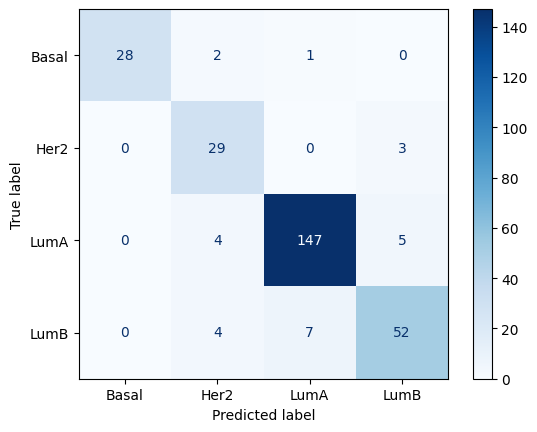

In [27]:
# Confusion matrix
plt.rcdefaults()
display = ConfusionMatrixDisplay.from_estimator(model, GPL18573_feature, GPL18573_target,
                                                display_labels = ["Basal", "Her2", "LumA", "LumB"],
                                                cmap = plt.cm.Blues, normalize = None)
plt.grid(False)
plt.show()

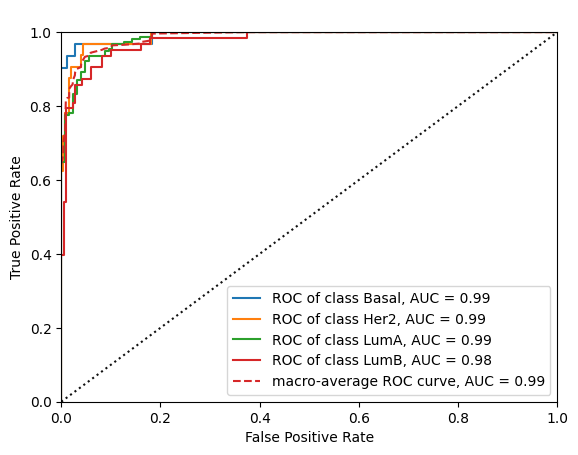

<Axes: title={'center': ' '}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [28]:
# ROC curve
plt.rcdefaults()
visualizer = ROCAUC(model, classes = ["Basal", "Her2", "LumA", "LumB"], macro = True, micro = False, title = " ", fontsize = 15)

visualizer.fit(X_res, y_res)        
visualizer.score(GPL18573_feature, GPL18573_target)
visualizer.show()

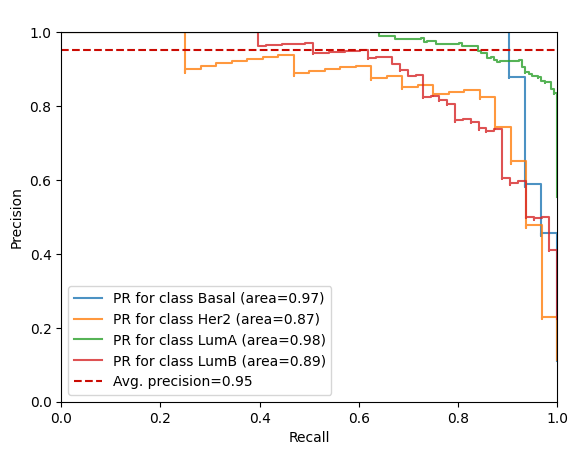

<Axes: title={'center': ' '}, xlabel='Recall', ylabel='Precision'>

In [29]:
# Precision-Recall curve
plt.rcdefaults()
visualizer = PrecisionRecallCurve(model, classes = ["Basal", "Her2", "LumA", "LumB"], micro = True, per_class = True, title = " ")

visualizer.fit(X_res, y_res)        
visualizer.score(GPL18573_feature, GPL18573_target)
visualizer.show()

In [30]:
# accuracy
accuracy_score(GPL18573_target, y_pred)

0.9078014184397163

In [31]:
# Macro average specificity
specificity_score(GPL18573_target, y_pred, average = "macro")

0.96499456403566

In [32]:
# Macro average sensitivity
sensitivity_score(GPL18573_target, y_pred, average = "macro")

0.8942950810390327

In [33]:
# Macro average F1 score
f1_score(GPL18573_target, y_pred, average = "macro")

0.8892300066717291

In [34]:
# Macro average AUROC
roc_auc_score(GPL18573_target, y_pred_proba, multi_class = "ovr", average = "macro")

0.986041000184942

### Model performance using independent data (GSE135298)

In [35]:
# Load test gene expression dataset (GSE135298).
# The gene expression values were defined as log2(TPM + 1).
GSE135298_feature = pd.read_csv("/home/wjddns037/Code/Project_code/GSE135298_feature_scale.csv", sep = "\t")
GSE135298_feature.index = GSE135298_feature.loc[:, "Unnamed: 0"].tolist()
GSE135298_feature = GSE135298_feature.drop(columns = ["Unnamed: 0"])

GSE135298_feature = GSE135298_feature.loc[:, X_train.columns.tolist()]
GSE135298_feature.shape

(82, 12)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'TMEM45B'),
  Text(1, 0, 'KCNJ11'),
  Text(2, 0, 'KRT5'),
  Text(3, 0, 'CDH3'),
  Text(4, 0, 'MAPT'),
  Text(5, 0, 'TYMS'),
  Text(6, 0, 'MYBL2'),
  Text(7, 0, 'FAM83D'),
  Text(8, 0, 'ESR1'),
  Text(9, 0, 'FOXC1'),
  Text(10, 0, 'NAT1'),
  Text(11, 0, 'SFRP1')])

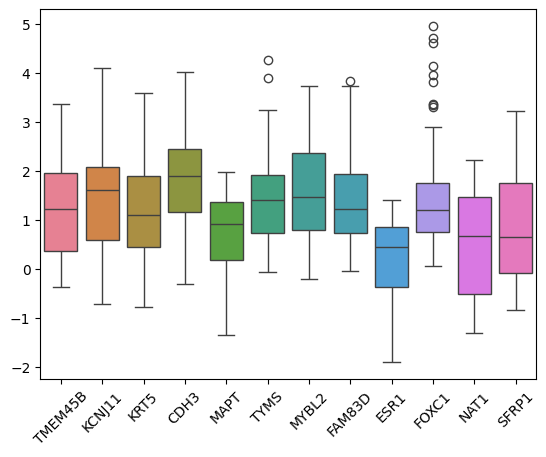

In [36]:
# Feature distritubion after normalization
plt.rcdefaults()
sns.boxplot(GSE135298_feature)
plt.xticks(rotation = 45)

In [37]:
# Load test PAM50 dataset.
GSE135298_target = pd.read_csv("/home/wjddns037/Code/Project_code/GSE135298_PAM50.csv", sep = "\t")
GSE135298_target.index = GSE135298_target.loc[:, "Unnamed: 0"].tolist()
GSE135298_target = GSE135298_target.drop(axis = 1, columns = ["Unnamed: 0"])

GSE135298_target = encoder.transform(GSE135298_target)
GSE135298_target

array([3, 2, 2, 3, 3, 1, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 3, 1, 2, 3, 2,
       2, 0, 3, 3, 1, 2, 1, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 3, 2, 3, 2, 0,
       0, 2, 3, 0, 2, 3, 2, 0, 3, 2, 3, 2, 0, 0, 3, 0, 2, 0, 2, 2, 2, 1,
       0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 1, 3, 2, 3, 3])

In [38]:
# Prediction
y_pred = model.predict(GSE135298_feature)
y_pred_proba = model.predict_proba(GSE135298_feature)

In [39]:
# Classification report
print(classification_report(GSE135298_target, y_pred, target_names = ["Basal", "Her2", "LumA", "LumB"]))

              precision    recall  f1-score   support

       Basal       1.00      0.85      0.92        13
        Her2       0.39      1.00      0.56         7
        LumA       0.97      0.93      0.95        42
        LumB       0.92      0.60      0.73        20

    accuracy                           0.84        82
   macro avg       0.82      0.84      0.79        82
weighted avg       0.92      0.84      0.86        82



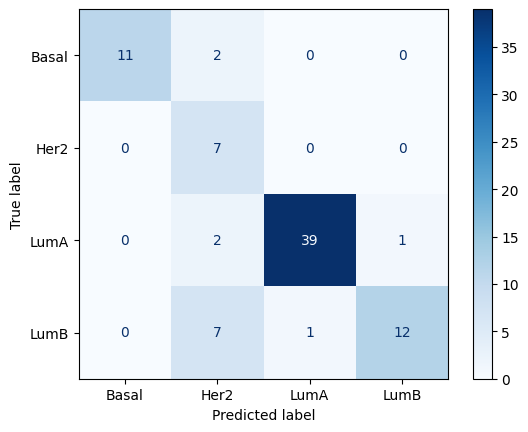

In [40]:
# Confusion matrix
plt.rcdefaults()
display = ConfusionMatrixDisplay.from_estimator(model, GSE135298_feature, GSE135298_target,
                                                display_labels = ["Basal", "Her2", "LumA", "LumB"],
                                                cmap = plt.cm.Blues, normalize = None)
plt.grid(False)
plt.show()

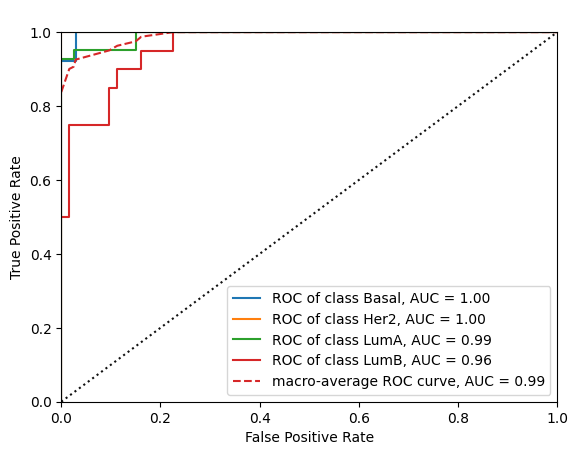

<Axes: title={'center': ' '}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [41]:
# ROC curve
plt.rcdefaults()
visualizer = ROCAUC(model, classes = ["Basal", "Her2", "LumA", "LumB"], macro = True, micro = False, title = " ", fontsize = 15)

visualizer.fit(X_res, y_res)        
visualizer.score(GSE135298_feature, GSE135298_target)
visualizer.show()

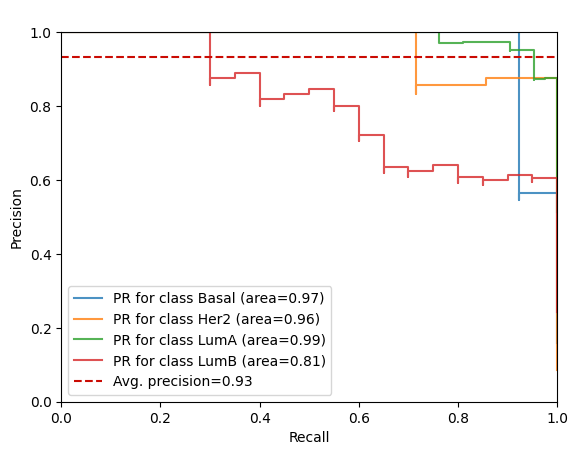

<Axes: title={'center': ' '}, xlabel='Recall', ylabel='Precision'>

In [42]:
# Precision-Recall curve
plt.rcdefaults()
visualizer = PrecisionRecallCurve(model, classes = ["Basal", "Her2", "LumA", "LumB"], micro = True, per_class = True, title = " ")

visualizer.fit(X_res, y_res)        
visualizer.score(GSE135298_feature, GSE135298_target)
visualizer.show()

In [43]:
# accuracy
accuracy_score(GSE135298_target, y_pred)

0.8414634146341463

In [44]:
# Macro average specificity
specificity_score(GSE135298_target, y_pred, average = "macro")

0.9530510752688173

In [45]:
# Macro average sensitivity
sensitivity_score(GSE135298_target, y_pred, average = "macro")

0.8436813186813187

In [46]:
# Macro average F1 score
f1_score(GSE135298_target, y_pred, average = "macro")

0.788789726533629

In [47]:
# Macro average AUROC
roc_auc_score(GSE135298_target, y_pred_proba, multi_class = "ovr", average = "macro")

0.9878306432347455